In [1]:
import matplotlib.pyplot as plt
from imp import reload
from typing import List
import os
import pickle
from skimage.io import imread
from skimage.color import rgb2gray
import pandas as pd
import sys

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from data_utils import DataHandler
import evaluate
import histogram_processing
import similarities
import bg_masks
import image_utils

N_PROCESS = 8

/tmp/ipykernel_64215/2841357593.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


## Load Data

In [2]:
# Load Data
data_handler = DataHandler(n_process=N_PROCESS)
db, db_files = data_handler.load_images(
    folder=".././data/BBDD/", extension=".jpg", desc="Loading BBDD Data...")

qsd1_w1, qsd1_w1_files = data_handler.load_images(
    folder="../data/qsd1_w1/", extension=".jpg", desc="Loading qsd1_w1 Data...")
# qst1_w1, qst1_w1_files = data_handler.load_images(folder = "../data/qst1_w1/", extension = ".png", desc = "Loading qst1_w1 Data...")



Initialized DataHandler with 8 processes


Loading BBDD Data...: 100%|██████████| 287/287 [00:34<00:00,  8.26it/s]


.././data/BBDD/ read: 287 images


Loading qsd1_w1 Data...: 100%|██████████| 30/30 [00:00<00:00, 751.25it/s]


../data/qsd1_w1/ read: 30 images


### Visualize some samples

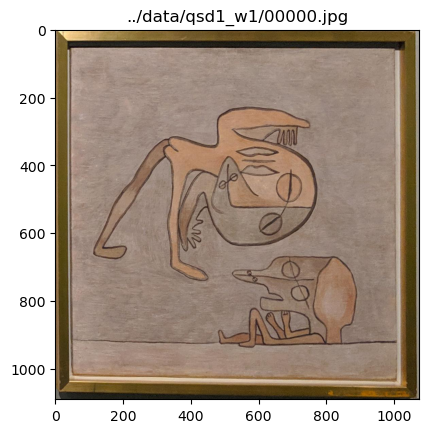

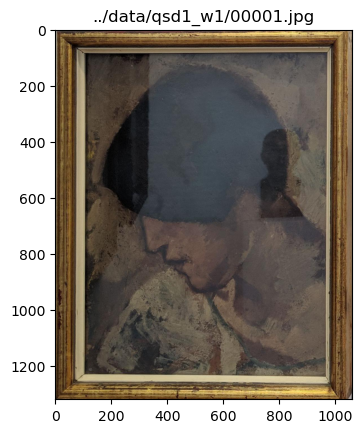

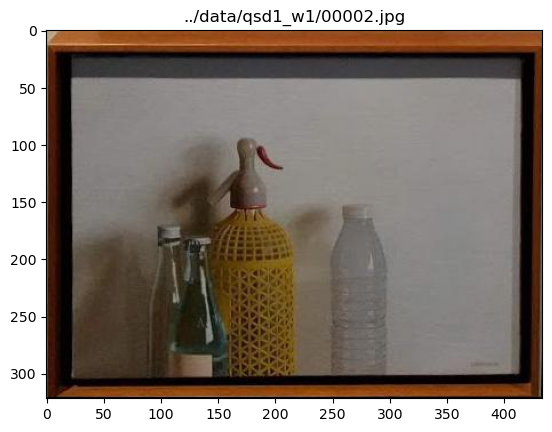

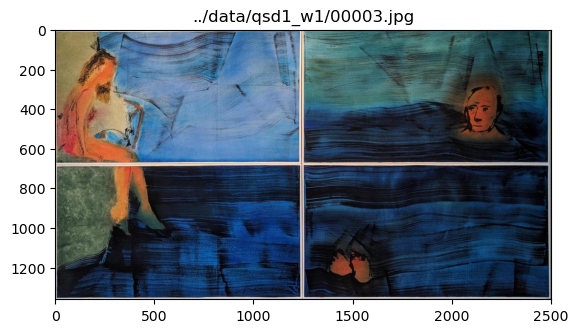

In [3]:
for img, filename in zip(qsd1_w1[:4], qsd1_w1_files[:4]):
    plt.imshow(img)
    plt.title(filename)
    plt.show()

## Similarity Measures

### Computing histograms

In [4]:
qs1_similarity_matrix = similarities.compute_similarities_batch(qsd1_w1[:], db[:], 'hellinger_kernel', n_bins=16, grayscale=False, RGB=False, CieLab=False, HSV=True, YCbCr=False,
                                                   mssg="Computing similarities for qsd1...(with N_PROCESS = {})".format(N_PROCESS), N_PROCESS=N_PROCESS)

%store qs1_similarity_matrix


Generating features for query dataset...(with N_PROCESS = 8): 100%|██████████| 30/30 [00:00<00:00, 326.18it/s]


query_features.shape (30, 48)


Generating features for BBDD dataset...(with N_PROCESS = 8): 100%|██████████| 287/287 [00:28<00:00, 10.23it/s]


db_feature_matrix.shape (287, 48)


Computing similarities for qsd1...(with N_PROCESS = 8): 100%|██████████| 30/30 [00:00<00:00, 105.53it/s]

Stored 'qs1_similarity_matrix' (list)


In [5]:
top_k_qs1 = evaluate.get_top_k(similarity_matrix=qs1_similarity_matrix, db_files=db_files,
                      k=10, mssg="Retrieving top K similar images for qs1...")

Retrieving top K similar images for qs1...: 100%|██████████| 30/30 [00:00<00:00, 15129.15it/s]


In [6]:
predicted_results_qs1 = data_handler.store_outputs_single(top_k_qs1, "./QST1/histograms", save=True)
expected_results_qs1 = pickle.load(open('../data/qsd1_w1/gt_corresps.pkl', "rb"))

mapk_qs1 = evaluate.mapk(expected_results_qs1, predicted_results_qs1, k=10)

print("MAP@K Score: {:.4f}% ({}/{})".format(mapk_qs1*100,
      int(len(predicted_results_qs1)*mapk_qs1), len(predicted_results_qs1)))

Results saved at ./QST1/histograms/result.pkl
MAP@K Score: 60.8611% (18/30)


In [7]:
def plot_image_and_similar(qs, top_k_qs) -> None:

    for i in range(min(10, len(qs))):
        f, axarr = plt.subplots(1, 2, figsize=(10, 10))
        base = qs[i]
        query = imread(top_k_qs[i][0])
        axarr[0].imshow(base)
        axarr[0].title.set_text("Base")
        axarr[1].imshow(query)
        axarr[1].title.set_text("Query")
        plt.show()


In [8]:
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd

def run_experiments():
    colorspaces = ('grayscale', 'RGB', 'CieLab', 'YCbCr', 'HSV')
    distance_measures = ('euclidean_distance', 'l1_distance', 'chi_square_distance', 'histogram_intersection', 'hellinger_kernel', 'cosine_similarity', 'histogram_correlation')

    eval_data = []
    for colorspace in colorspaces:
        for distance_name in distance_measures:
            print("Evaluating {} with distance measure {}".format(colorspace, distance_name))
            if not os.path.isfile("../results/data/dist_{}_{}.pkl".format(colorspace, distance_name)):
                query_features = data_handler.load_object_pickle("../results/data/features_qsd1_{}.pkl".format(colorspace))
                db_feature_matrix = data_handler.load_object_pickle("../results/data/features_DDBB_{}.pkl".format(colorspace))
                dist = Parallel(n_jobs=N_PROCESS)(delayed(similarities.compute_similarities)(
                    query_img, db_feature_matrix, similarities.measures[distance_name]) for query_img in tqdm(query_features, desc="Computing similarities for {} with distance measure {}".format(colorspace, distance_name))
                )
                data_handler.save_object_pickle(dist, "../results/data/dist_{}_{}.pkl".format(colorspace, distance_name))
            else:
                dist = data_handler.load_object_pickle("../results/data/dist_{}_{}.pkl".format(colorspace, distance_name))
            for k in (1,5,10):
                top_k = evaluate.get_top_k(similarity_matrix=dist, db_files=db_files,
                                        k=k, mssg=f"Retrieving top K similar images for qs1, distance measure {distance_name} and color space {colorspace}...")

                predicted_results = data_handler.store_outputs_single(top_k, "../results/data/pred_{}_{}.pkl".format(colorspace, distance_name), save=True)
                expected_results_qs1 = pickle.load(open('../data/qsd1_w1/gt_corresps.pkl', "rb"))

                mapk_qs1 = evaluate.mapk(expected_results_qs1, predicted_results, k=k)

                print("MAP@{} Score: {:.4f}% ({}/{})".format(k, mapk_qs1*100, int(len(predicted_results)*mapk_qs1), len(predicted_results)))
                eval_data.append([colorspace, distance_name, k, mapk_qs1*100, int(len(predicted_results)*mapk_qs1), len(predicted_results)])
            break
        break

    dataframe = pd.DataFrame(eval_data, columns=['Color space', 'Distance', 'K', 'MapK', 'correct', 'total'])
    dataframe.to_csv("../results/eval_colorspace_distance.csv", index=False)

# Background

In [4]:
qsd2_w1, qsd2_w1_files = data_handler.load_images(folder="../data/qsd2_w1/", extension=".jpg", desc="Loading qsd2_w1 Data...")
qsd2_w1_masks, qsd2_w1_masks_files = data_handler.load_images(folder="../data/qsd2_w1/", extension=".png", desc="Loading qsd2_w1 Masks...")

Loading qsd2_w1 Data...: 100%|██████████| 30/30 [00:00<00:00, 434.65it/s]


../data/qsd2_w1/ read: 30 images


Loading qsd2_w1 Masks...: 100%|██████████| 30/30 [00:00<00:00, 960.15it/s]


../data/qsd2_w1/ read: 30 images


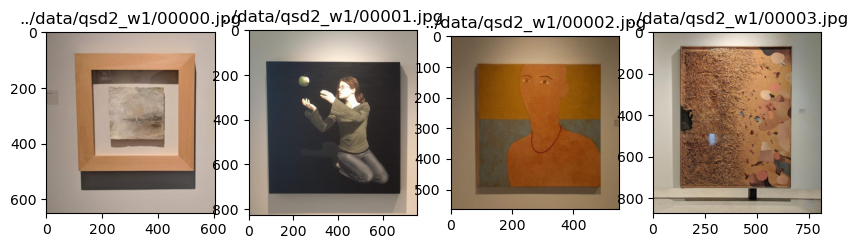

In [10]:
f, axarr = plt.subplots(1, 4, figsize=(10, 10))
for img, filename in zip(qsd2_w1[:4], qsd2_w1_files[:4]):
    axarr[qsd2_w1_files.index(filename)].imshow(img)
    axarr[qsd2_w1_files.index(filename)].title.set_text(filename)
plt.show()

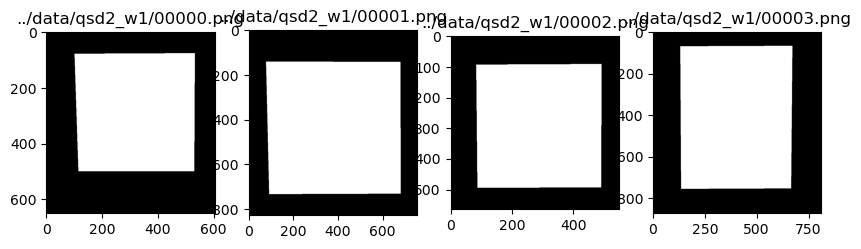

In [11]:
f, axarr = plt.subplots(1, 4, figsize=(10, 10))
for img, filename in zip(qsd2_w1_masks[:4], qsd2_w1_masks_files[:4]):
    axarr[qsd2_w1_masks_files.index(filename)].imshow(img, cmap='binary_r')
    axarr[qsd2_w1_masks_files.index(filename)].title.set_text(filename)
plt.show()

### Mean background method

In [12]:
bg_masks.generate_masks_meanBackground(
    query_images_paths='../data/qsd2_w1/',
    output_dir='../data/mean_masks_w1/',
)

100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


In [13]:
evaluate.run_evaluation_masks_meanBackground(
    gt_path='../data/qsd2_w1',
    input_path='../data/mean_masks_w1',
    output_csv_path='../results/mean_masks_method_metrics.csv',
)

100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


['RGB', 4, 0.7603025136085791, 0.548394373411123, 0.587635771040048]
['RGB', 10, 0.7548694932381177, 0.5335157322871394, 0.578484602376673]


  0%|          | 0/3 [00:00<?, ?it/s]

['RGB', 2, 0.7682400507883212, 0.5660717291541882, 0.6052866509922378]


100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


['CieLab', 4, 0.9135900338448653, 0.9003187479536616, 0.8851364679371794]


  0%|          | 0/3 [00:00<?, ?it/s]

['CieLab', 10, 0.9123920161289835, 0.899344858400385, 0.8839099848830162]
['CieLab', 2, 0.9153314030792765, 0.9000963882034225, 0.8858147061958517]


100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

['YCbCr', 2, 0.7648151002691633, 0.5076812681150594, 0.5627121148149727]
['YCbCr', 4, 0.7643904796774398, 0.49730698063085615, 0.5578906139205447]
['YCbCr', 10, 0.7643572732586957, 0.5263450092697846, 0.5821639133223846]


['HSV', 2, 0.8885659857117607, 0.8895387357195855, 0.8628675312879948]
['HSV', 10, 0.8741059313807933, 0.900604332773084, 0.8612756251022865]
['HSV', 4, 0.8759736310289038, 0.8987536395550685, 0.8614927752882215]


In [14]:
# Load data of best Masks experiment
color_space = 'CieLab'
frame_size = 10

masks_gen_mean, masks_gen_mean_files = data_handler.load_images(
    folder=f".././data/mean_masks_w1/{color_space}/{frame_size}/", extension=".png", desc=f"Loading 'mean' masks color={color_space}, frame={frame_size} Data...")

Loading 'mean' masks color=CieLab, frame=10 Data...: 100%|██████████| 30/30 [00:01<00:00, 17.52it/s]

.././data/mean_masks_w1/CieLab/10/ read: 30 images


In [15]:
imgs_cropped_mean = [image_utils.crop_image(img, mask) for img, mask in zip(qsd2_w1, masks_gen_mean)]

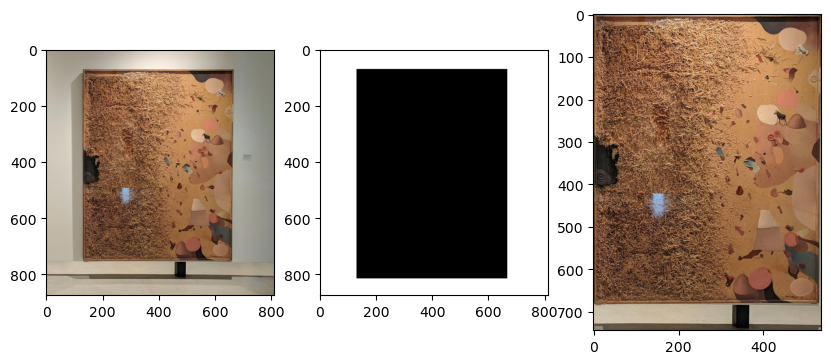

In [16]:
idx = 3

f, axarr = plt.subplots(1, 3, figsize=(10, 10))
# for img, filename in zip(qsd2_w1[:4], qsd2_w1_files[:4]):
axarr[0].imshow(qsd2_w1[idx], cmap='binary')
axarr[1].imshow(masks_gen_mean[idx], cmap='binary')
axarr[2].imshow(imgs_cropped_mean[idx], cmap='binary')
plt.show()

In [17]:
qs2_similarity_matrix_mean = similarities.compute_similarities_batch(imgs_cropped_mean[:], db[:], 'hellinger_kernel',
                                                n_bins=16, grayscale=False, RGB=False, CieLab=False, HSV=True, YCbCr=False,
                                                mssg="Computing similarities for qsd2 cropped...(with N_PROCESS = {})".format(N_PROCESS), N_PROCESS=N_PROCESS)

%store qs2_similarity_matrix_mean

Generating features for query dataset...(with N_PROCESS = 8): 100%|██████████| 30/30 [00:00<00:00, 425.70it/s]


query_features.shape (30, 48)


Generating features for BBDD dataset...(with N_PROCESS = 8):   6%|▌         | 16/287 [00:00<00:03, 81.62it/s]/Users/johnny/miniforge3/envs/Team1/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Generating features for BBDD dataset...(with N_PROCESS = 8): 100%|██████████| 287/287 [00:27<00:00, 10.31it/s]


db_feature_matrix.shape (287, 48)


Computing similarities for qsd2 cropped...(with N_PROCESS = 8): 100%|██████████| 30/30 [00:00<00:00, 111.76it/s]

Stored 'qs2_similarity_matrix_mean' (list)


In [18]:
top_1_qs2_mean = evaluate.get_top_k(similarity_matrix=qs2_similarity_matrix_mean, db_files=db_files,
                                    k=1, mssg="Retrieving top 1 similar images for qs1...")
top_5_qs2_mean = evaluate.get_top_k(similarity_matrix=qs2_similarity_matrix_mean, db_files=db_files,
                                    k=5, mssg="Retrieving top 5 similar images for qs1...")

Retrieving top 5 similar images for qs1...: 100%|██████████| 30/30 [00:00<00:00, 22125.75it/s]


In [19]:
predicted_results_mean1 = data_handler.store_outputs_single(top_1_qs2_mean, "./QST2/mean", save=True)
expected_results = pickle.load(open('../data/qsd2_w1/gt_corresps.pkl', "rb"))

mapk_qs2_mean1 = evaluate.mapk(expected_results, predicted_results_mean1, k=1)

print("MAP@1 Score: {:.4f}% ({}/{})".format(mapk_qs2_mean1*100,
      int(len(predicted_results_mean1)*mapk_qs2_mean1), len(predicted_results_mean1)))

Results saved at ./QST2/mean/result.pkl
MAP@1 Score: 36.6667% (11/30)


In [20]:
predicted_results_mean5 = data_handler.store_outputs_single(top_5_qs2_mean, "./QST2/mean", save=True)
expected_results = pickle.load(open('../data/qsd2_w1/gt_corresps.pkl', "rb"))

mapk_qs2_mean5 = evaluate.mapk(expected_results, predicted_results_mean5, k=5)

print("MAP@5 Score: {:.4f}% ({}/{})".format(mapk_qs2_mean5*100,
      int(len(predicted_results_mean5)*mapk_qs2_mean5), len(predicted_results_mean5)))

Results saved at ./QST2/mean/result.pkl
MAP@5 Score: 42.3333% (12/30)


In [21]:
eval_data = [
    ['mean', 'hellinger_kernel', 1, mapk_qs2_mean1, int(len(predicted_results_mean1)*mapk_qs2_mean1), len(predicted_results_mean1) ],
    ['mean', 'hellinger_kernel', 5, mapk_qs2_mean5, int(len(predicted_results_mean5)*mapk_qs2_mean5), len(predicted_results_mean5) ]
]
dataframe = pd.DataFrame(eval_data, columns=['Background method', 'Distance', 'K', 'MapK', 'correct', 'total'])
dataframe.to_csv("../results/eval_background_mean.csv", index=False)

### Otsu method

In [22]:
reload(bg_masks)
bg_masks.generate_masks(query_images_paths=qsd2_w1_files, output_dir='../data/otsu_masks_w1/', method="otsu", th=92)

Generating masks with Otsu's method:   3%|▎         | 1/30 [00:00<00:18,  1.58it/s]/Users/johnny/Projects/Team1/week1/../bg_masks.py:160: RuntimeWarning: invalid value encountered in double_scalars
  m0 = np.sum(prob[:t] * bin_mids[:t]) / w0
/Users/johnny/Projects/Team1/week1/../bg_masks.py:160: RuntimeWarning: invalid value encountered in double_scalars
  m0 = np.sum(prob[:t] * bin_mids[:t]) / w0
/Users/johnny/Projects/Team1/week1/../bg_masks.py:160: RuntimeWarning: invalid value encountered in double_scalars
  m0 = np.sum(prob[:t] * bin_mids[:t]) / w0
/Users/johnny/Projects/Team1/week1/../bg_masks.py:160: RuntimeWarning: invalid value encountered in double_scalars
  m0 = np.sum(prob[:t] * bin_mids[:t]) / w0
Generating masks with Otsu's method: 100%|██████████| 30/30 [00:02<00:00, 13.25it/s]


In [23]:
reload(evaluate)
evaluate.run_evaluation_masks_otsu(
    gt_path='../data/qsd2_w1',
    input_path='../data/otsu_masks_w1',
    output_csv_path='../results/otsu_masks_metrics.csv',
)

[0.9347519160344682, 0.9432306722132225, 0.9219660240959257]


In [24]:
# data_handler = DataHandler(n_process=N_PROCESS)
masks_gen_otsu, masks_gen_mean_otsu = data_handler.load_images(
    folder=f".././data/otsu_masks_w1/", extension=".png", desc=f"Loading 'otsu' masks Data...")

Loading 'otsu' masks Data...: 100%|██████████| 30/30 [00:01<00:00, 18.51it/s]

.././data/otsu_masks_w1/ read: 30 images


In [25]:
imgs_cropped_otsu = [image_utils.crop_image(img, mask) for img, mask in zip(qsd2_w1, masks_gen_otsu)]

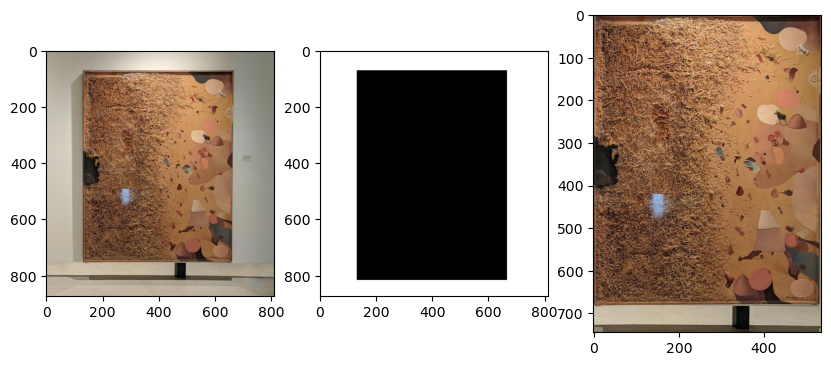

In [26]:
idx = 3

f, axarr = plt.subplots(1, 3, figsize=(10, 10))
# for img, filename in zip(qsd2_w1[:4], qsd2_w1_files[:4]):
axarr[0].imshow(qsd2_w1[idx], cmap='binary')
axarr[1].imshow(masks_gen_otsu[idx], cmap='binary')
axarr[2].imshow(imgs_cropped_otsu[idx], cmap='binary')
plt.show()

In [27]:
qs2_similarity_matrix_otsu = similarities.compute_similarities_batch(imgs_cropped_otsu[:], db[:], 'hellinger_kernel',
                                                n_bins=16, grayscale=False, RGB=False, CieLab=False, HSV=True, YCbCr=False,
                                                mssg="Computing similarities for qsd2 cropped...(with N_PROCESS = {})".format(N_PROCESS), N_PROCESS=N_PROCESS)

# %store qs2_similarity_matrix_otsu

Generating features for query dataset...(with N_PROCESS = 8): 100%|██████████| 30/30 [00:00<00:00, 376.94it/s]
/Users/johnny/miniforge3/envs/Team1/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


query_features.shape (30, 48)


Generating features for BBDD dataset...(with N_PROCESS = 8): 100%|██████████| 287/287 [00:26<00:00, 10.74it/s]


db_feature_matrix.shape (287, 48)


Computing similarities for qsd2 cropped...(with N_PROCESS = 8): 100%|██████████| 30/30 [00:00<00:00, 101.11it/s]


In [28]:
top_1_qs2_otsu = evaluate.get_top_k(similarity_matrix=qs2_similarity_matrix_otsu, db_files=db_files,
                                    k=1, mssg="Retrieving top 1 similar images for qs1...")
top_5_qs2_otsu = evaluate.get_top_k(similarity_matrix=qs2_similarity_matrix_otsu, db_files=db_files,
                                    k=5, mssg="Retrieving top 5 similar images for qs1...")

Retrieving top 5 similar images for qs1...: 100%|██████████| 30/30 [00:00<00:00, 17993.58it/s]


In [29]:
predicted_results_otsu1 = data_handler.store_outputs_single(top_1_qs2_otsu, "./QST2/otsu", save=True)
expected_results = pickle.load(open('../data/qsd2_w1/gt_corresps.pkl', "rb"))

mapk_qs2_otsu1 = evaluate.mapk(expected_results, predicted_results_otsu1, k=1)

print("MAP@K Score: {:.4f}% ({}/{})".format(mapk_qs2_otsu1*100,
      int(len(predicted_results_otsu1)*mapk_qs2_otsu1), len(predicted_results_otsu1)))

Results saved at ./QST2/otsu/result.pkl
MAP@K Score: 43.3333% (13/30)


In [30]:
predicted_results_otsu5 = data_handler.store_outputs_single(top_5_qs2_otsu, "./QST2/otsu", save=True)
expected_results = pickle.load(open('../data/qsd2_w1/gt_corresps.pkl', "rb"))

mapk_qs2_otsu5 = evaluate.mapk(expected_results, predicted_results_otsu5, k=5)

print("MAP@K Score: {:.4f}% ({}/{})".format(mapk_qs2_otsu5*100,
      int(len(predicted_results_otsu5)*mapk_qs2_otsu5), len(predicted_results_otsu5)))

Results saved at ./QST2/otsu/result.pkl
MAP@K Score: 46.6667% (14/30)


In [31]:
eval_data = [
    ['otsu', 'hellinger_kernel', 1, mapk_qs2_otsu1, int(len(predicted_results_otsu1)*mapk_qs2_otsu1), len(predicted_results_otsu1) ],
    ['otsu', 'hellinger_kernel', 5, mapk_qs2_otsu5, int(len(predicted_results_otsu5)*mapk_qs2_otsu5), len(predicted_results_otsu5) ]
]
dataframe = pd.DataFrame(eval_data, columns=['Background method', 'Distance', 'K', 'MapK', 'correct', 'total'])
dataframe.to_csv("../results/eval_background_otsu.csv", index=False)

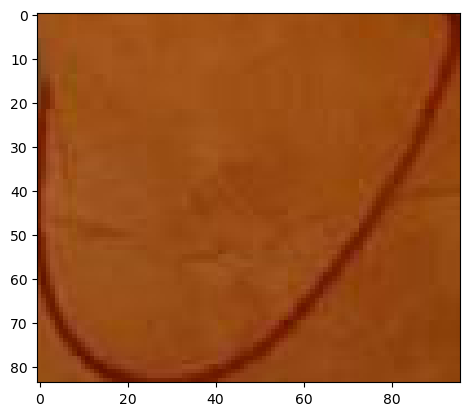

In [32]:
plt.imshow(imgs_cropped_otsu[2], cmap='binary')

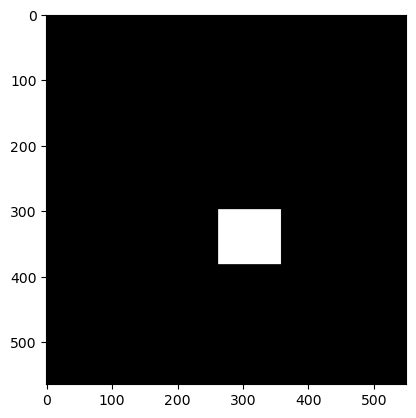

In [33]:
plt.imshow(masks_gen_otsu[2], cmap='binary_r')

### Flood fill method

In [5]:
reload(bg_masks)
masks_gen_floodFill = bg_masks.generate_masks_floodFill(
    qsd2_w1,
    N_PROCESS=N_PROCESS,
    mssg="Generating masks with floodfill method... (N_PROCESS = {})".format(N_PROCESS),
    image_files=qsd2_w1_files,
    output_dir='../data/floodFill_masks_w1/'
)

# TODO: save masks to disk
imgs_cropped_floodFill = [image_utils.crop_image(img, mask) for img, mask in zip(qsd2_w1, masks_gen_floodFill)]

Generating masks with floodfill method... (N_PROCESS = 8): 100%|██████████| 30/30 [00:31<00:00,  1.04s/it]
Eroding masks...: 100%|██████████| 30/30 [00:00<00:00, 738.21it/s]


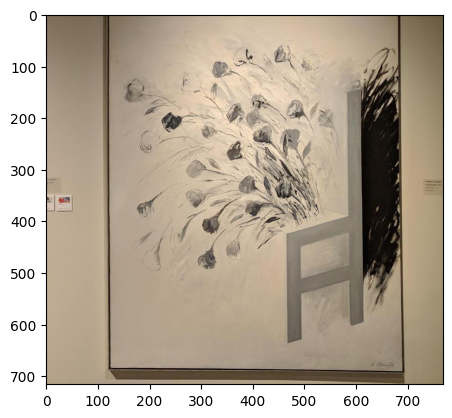

In [10]:
plt.imshow(imgs_cropped_floodFill[20], cmap='binary')

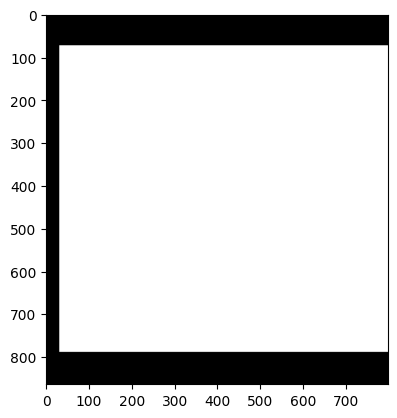

In [11]:
plt.imshow(masks_gen_floodFill[20], cmap='binary_r')

In [37]:
precisions, recalls, f1_scores = evaluate.evaluate_masks(masks_gen_floodFill, qsd2_w1_masks)

Precision: 98.8798%
Recall: 72.4037%
F1 Score: 82.4366%


In [38]:
qs2_similarity_matrix_floodFill = similarities.compute_similarities_batch(imgs_cropped_floodFill[:], db[:], 'hellinger_kernel',
                                                n_bins=16, grayscale=False, RGB=False, CieLab=False, HSV=True, YCbCr=False,
                                                mssg="Computing similarities for qsd2 cropped...(with N_PROCESS = {})".format(N_PROCESS), N_PROCESS=N_PROCESS)

Generating features for query dataset...(with N_PROCESS = 8): 100%|██████████| 30/30 [00:00<00:00, 719.27it/s]


query_features.shape (30, 48)


Generating features for BBDD dataset...(with N_PROCESS = 8): 100%|██████████| 287/287 [00:25<00:00, 11.10it/s]


db_feature_matrix.shape (287, 48)


Computing similarities for qsd2 cropped...(with N_PROCESS = 8): 100%|██████████| 30/30 [00:00<00:00, 124.44it/s]


In [39]:
top_1_qs2_floodFill = evaluate.get_top_k(similarity_matrix=qs2_similarity_matrix_floodFill, db_files=db_files,
                                         k=1, mssg="Retrieving top 1 similar images for qs1...")
top_5_qs2_floodFill = evaluate.get_top_k(similarity_matrix=qs2_similarity_matrix_floodFill, db_files=db_files,
                                         k=5, mssg="Retrieving top 5 similar images for qs1...")

Retrieving top 5 similar images for qs1...: 100%|██████████| 30/30 [00:00<00:00, 16619.88it/s]


In [40]:
predicted_results_floodFill1 = data_handler.store_outputs_single(top_1_qs2_floodFill, "./QST2/floodFill", save=True)
expected_results = pickle.load(open('../data/qsd2_w1/gt_corresps.pkl', "rb"))

mapk_qs2_floodFill1 = evaluate.mapk(expected_results, predicted_results_floodFill1, k=1)

print("MAP@1 Score: {:.4f}% ({}/{})".format(mapk_qs2_floodFill1*100,
      int(len(predicted_results_floodFill1)*mapk_qs2_floodFill1), len(predicted_results_floodFill1)))

predicted_results_floodFill5 = data_handler.store_outputs_single(top_1_qs2_floodFill, "./QST2/floodFill", save=True)
expected_results = pickle.load(open('../data/qsd2_w1/gt_corresps.pkl', "rb"))

mapk_qs2_floodFill5 = evaluate.mapk(expected_results, predicted_results_floodFill5, k=10)

print("MAP@K Score: {:.4f}% ({}/{})".format(mapk_qs2_floodFill5*100,
      int(len(predicted_results_floodFill5)*mapk_qs2_floodFill5), len(predicted_results_floodFill5)))

Results saved at ./QST2/floodFill/result.pkl
MAP@1 Score: 30.0000% (9/30)
Results saved at ./QST2/floodFill/result.pkl
MAP@K Score: 30.0000% (9/30)


In [41]:
eval_data = [
    ['flood_fill', 'hellinger_kernel', 1, mapk_qs2_floodFill1, int(len(predicted_results_floodFill1)*mapk_qs2_floodFill1), len(predicted_results_floodFill1) ],
    ['flood_fill', 'hellinger_kernel', 5, mapk_qs2_floodFill5, int(len(predicted_results_floodFill5)*mapk_qs2_floodFill5), len(predicted_results_floodFill5) ]
]
dataframe = pd.DataFrame(eval_data, columns=['Background method', 'Distance', 'K', 'MapK', 'correct', 'total'])
dataframe.to_csv("../results/eval_background_floodFill.csv", index=False)

# TEST

In [42]:
test, test_files = data_handler.load_images(
    folder="../data/Test/qst1_w1/",
    extension=".jpg",
    desc="Loading Test Data..."
)

Loading Test Data...: 100%|██████████| 30/30 [00:00<00:00, 102.98it/s]

../data/Test/qst1_w1/ read: 30 images


# TASK 1

#### HSV

In [43]:
qs1_similarity_matrix_test = similarities.compute_similarities_batch(
    test[:], db[:],
    'hellinger_kernel', n_bins=16,
    grayscale=False, RGB=False, CieLab=False, HSV=True, YCbCr=False,
    mssg="Computing similarities for qst1...(with N_PROCESS = {})".format(N_PROCESS),
    N_PROCESS=N_PROCESS
)

Generating features for query dataset...(with N_PROCESS = 8): 100%|██████████| 30/30 [00:00<00:00, 1079.76it/s]
/Users/johnny/miniforge3/envs/Team1/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


query_features.shape (30, 48)


Generating features for BBDD dataset...(with N_PROCESS = 8): 100%|██████████| 287/287 [00:26<00:00, 10.86it/s]


db_feature_matrix.shape (287, 48)


Computing similarities for qst1...(with N_PROCESS = 8): 100%|██████████| 30/30 [00:00<00:00, 121.27it/s]


In [44]:
top_k_test = evaluate.get_top_k(
    similarity_matrix=qs1_similarity_matrix_test,
    db_files=db_files,
    k=10,
    mssg="Retrieving top K similar images for TEST..."
)

Retrieving top K similar images for TEST...: 100%|██████████| 30/30 [00:00<00:00, 12274.81it/s]


In [45]:
predicted_results_test = data_handler.store_outputs_single(top_k_test, "./QST1/TEST/histograms/HSV/", save=True)

Results saved at ./QST1/TEST/histograms/HSV//result.pkl


#### CieLab

In [46]:
qs1_similarity_matrix_test = similarities.compute_similarities_batch(
    test[:], db[:],
    'hellinger_kernel', n_bins=16,
    grayscale=False, RGB=False, CieLab=True, HSV=False, YCbCr=False,
    mssg="Computing similarities for qst1...(with N_PROCESS = {})".format(N_PROCESS),
    N_PROCESS=N_PROCESS
)

Generating features for query dataset...(with N_PROCESS = 8): 100%|██████████| 30/30 [00:00<00:00, 608.90it/s]


query_features.shape (30, 48)


Generating features for BBDD dataset...(with N_PROCESS = 8): 100%|██████████| 287/287 [00:27<00:00, 10.41it/s]


db_feature_matrix.shape (287, 48)


Computing similarities for qst1...(with N_PROCESS = 8): 100%|██████████| 30/30 [00:00<00:00, 97.54it/s]


In [47]:
top_k_test = evaluate.get_top_k(
    similarity_matrix=qs1_similarity_matrix_test,
    db_files=db_files,
    k=10,
    mssg="Retrieving top K similar images for TEST..."
)

Retrieving top K similar images for TEST...: 100%|██████████| 30/30 [00:00<00:00, 14519.86it/s]


In [48]:
predicted_results_test = data_handler.store_outputs_single(top_k_test, "./QST1/TEST/histograms/CieLab/", save=True)

Results saved at ./QST1/TEST/histograms/CieLab//result.pkl


# TASK 2

In [49]:
test, test_files = data_handler.load_images(folder="../data/Test/qst2_w1/", extension=".jpg", desc="Loading Test Data...")

Loading Test Data...: 100%|██████████| 30/30 [00:00<00:00, 97.30it/s]

../data/Test/qst2_w1/ read: 30 images


## Mean

In [50]:
bg_masks.generate_masks_meanBackground(
    query_images_paths="../data/Test/qst2_w1/",
    output_dir='../data/Test/mean_masks_w1/'
)
masks_gen_mean_test, masks_gen_mean_files_test = data_handler.load_images(
    folder=f"../data/Test/mean_masks_w1/{color_space}/{frame_size}/",
    extension=".png", desc=f"Loading 'mean' masks color={color_space}, frame={frame_size} Data...")
imgs_cropped_mean = [image_utils.crop_image(img, mask) for img, mask in zip(test, masks_gen_mean_test)]

100%|██████████| 3/3 [00:04<00:00,  1.51s/it]
Loading 'mean' masks color=CieLab, frame=10 Data...: 100%|██████████| 30/30 [00:01<00:00, 16.55it/s]

../data/Test/mean_masks_w1/CieLab/10/ read: 30 images


In [51]:
test_similarity_matrix_mean = similarities.compute_similarities_batch(
    test[:], db[:], 'hellinger_kernel',
    n_bins=16, grayscale=False, RGB=False, CieLab=False, HSV=True, YCbCr=False,
    mssg="Computing similarities for TEST cropped...(with N_PROCESS = {})".format(N_PROCESS),
    N_PROCESS=N_PROCESS
)

Generating features for query dataset...(with N_PROCESS = 8): 100%|██████████| 30/30 [00:00<00:00, 325.25it/s]


query_features.shape (30, 48)


Generating features for BBDD dataset...(with N_PROCESS = 8): 100%|██████████| 287/287 [00:27<00:00, 10.34it/s]


db_feature_matrix.shape (287, 48)


Computing similarities for TEST cropped...(with N_PROCESS = 8): 100%|██████████| 30/30 [00:00<00:00, 121.28it/s]


In [52]:
top_k_test_mean = evaluate.get_top_k(
    similarity_matrix=test_similarity_matrix_mean,
    db_files=db_files, k=10, mssg="Retrieving top K similar images for TEST...")

Retrieving top K similar images for TEST...: 100%|██████████| 30/30 [00:00<00:00, 20877.57it/s]


In [53]:
predicted_results_mean = data_handler.store_outputs_single(top_k_test_mean, "./QST2/TEST/mean", save=True)

Results saved at ./QST2/TEST/mean/result.pkl


## Otsu Method

In [54]:
reload(bg_masks)
bg_masks.generate_masks(query_images_paths=test_files, output_dir='../data/Test/otsu_masks_w1/', method="otsu", th=92)
masks_gen_otsu_test, masks_gen_ots_test = data_handler.load_images(
    folder=f"../data/Test/otsu_masks_w1/",
    extension=".png",
    desc=f"Loading 'otsu' masks Data..."
)
imgs_cropped_otsu_test = [image_utils.crop_image(img, mask) for img, mask in zip(test, masks_gen_otsu_test)]

Generating masks with Otsu's method:   3%|▎         | 1/30 [00:00<00:19,  1.51it/s]/Users/johnny/Projects/Team1/week1/../bg_masks.py:160: RuntimeWarning: invalid value encountered in double_scalars
  m0 = np.sum(prob[:t] * bin_mids[:t]) / w0
/Users/johnny/Projects/Team1/week1/../bg_masks.py:160: RuntimeWarning: invalid value encountered in double_scalars
  m0 = np.sum(prob[:t] * bin_mids[:t]) / w0
/Users/johnny/Projects/Team1/week1/../bg_masks.py:160: RuntimeWarning: invalid value encountered in double_scalars
  m0 = np.sum(prob[:t] * bin_mids[:t]) / w0
Generating masks with Otsu's method:  27%|██▋       | 8/30 [00:02<00:05,  4.15it/s]/Users/johnny/Projects/Team1/week1/../bg_masks.py:160: RuntimeWarning: invalid value encountered in double_scalars
  m0 = np.sum(prob[:t] * bin_mids[:t]) / w0
Loading 'otsu' masks Data...: 100%|██████████| 30/30 [00:01<00:00, 16.67it/s]

../data/Test/otsu_masks_w1/ read: 30 images


In [55]:
test_similarity_matrix_otsu = similarities.compute_similarities_batch(
    imgs_cropped_otsu_test[:], db[:], 'hellinger_kernel',
    n_bins=16, grayscale=False, RGB=False, CieLab=False, HSV=True, YCbCr=False,
    mssg="Computing similarities for TEST cropped...(with N_PROCESS = {})".format(N_PROCESS),
    N_PROCESS=N_PROCESS
)

Generating features for query dataset...(with N_PROCESS = 8): 100%|██████████| 30/30 [00:00<00:00, 514.71it/s]


query_features.shape (30, 48)


Generating features for BBDD dataset...(with N_PROCESS = 8): 100%|██████████| 287/287 [00:26<00:00, 10.65it/s]


db_feature_matrix.shape (287, 48)


Computing similarities for TEST cropped...(with N_PROCESS = 8): 100%|██████████| 30/30 [00:00<00:00, 110.10it/s]


In [56]:
top_k_test_otsu = evaluate.get_top_k(similarity_matrix=test_similarity_matrix_otsu, db_files=db_files,
                                    k=10, mssg="Retrieving top K similar images for TEST...")

Retrieving top K similar images for TEST...: 100%|██████████| 30/30 [00:00<00:00, 17898.88it/s]


In [57]:
predicted_results_otsu = data_handler.store_outputs_single(top_k_test_otsu, "./QST2/TEST/otsu", save=True)

Results saved at ./QST2/TEST/otsu/result.pkl


## Flood Fill Method

In [58]:
reload(bg_masks)
masks_gen_floodFill_test = bg_masks.generate_masks_floodFill(
    test,
    N_PROCESS=N_PROCESS,
    mssg="Generating masks with floodfill method... (N_PROCESS = {})".format(N_PROCESS),
    image_files=test_files,
    output_dir='../data/Test/floodFill_masks_w1/'
)
# save flood fill masks
imgs_cropped_floodFill_test = [image_utils.crop_image(img, mask) for img, mask in zip(test, masks_gen_floodFill_test)]

Generating masks with floodfill method... (N_PROCESS = 8): 100%|██████████| 30/30 [00:02<00:00, 10.38it/s]
Eroding masks...: 100%|██████████| 30/30 [00:00<00:00, 1351.16it/s]


In [59]:
test_similarity_matrix_floodFill = similarities.compute_similarities_batch(
    imgs_cropped_floodFill_test[:], db[:], 'hellinger_kernel',
    n_bins=16, grayscale=False, RGB=False, CieLab=False, HSV=True, YCbCr=False,
    mssg="Computing similarities for TEST cropped...(with N_PROCESS = {})".format(N_PROCESS),
    N_PROCESS=N_PROCESS
)

Generating features for query dataset...(with N_PROCESS = 8): 100%|██████████| 30/30 [00:00<00:00, 1108.39it/s]


query_features.shape (30, 48)


Generating features for BBDD dataset...(with N_PROCESS = 8): 100%|██████████| 287/287 [00:27<00:00, 10.34it/s]


db_feature_matrix.shape (287, 48)


Computing similarities for TEST cropped...(with N_PROCESS = 8): 100%|██████████| 30/30 [00:00<00:00, 122.60it/s]


In [60]:
top_k_test_floodFill = evaluate.get_top_k(similarity_matrix=test_similarity_matrix_floodFill, db_files=db_files,
                                         k=10, mssg="Retrieving top K similar images for TEST...")

Retrieving top K similar images for TEST...: 100%|██████████| 30/30 [00:00<00:00, 20132.66it/s]


In [61]:
predicted_results_floodFill = data_handler.store_outputs_single(top_k_test_floodFill, "./QST2/TEST/floodFill", save=True)

Results saved at ./QST2/TEST/floodFill/result.pkl
